<a href="https://colab.research.google.com/github/trindaderafa/imersao-dados-desafio-final/blob/main/First_Portfolio_in_Data_Science_Drugdiscovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

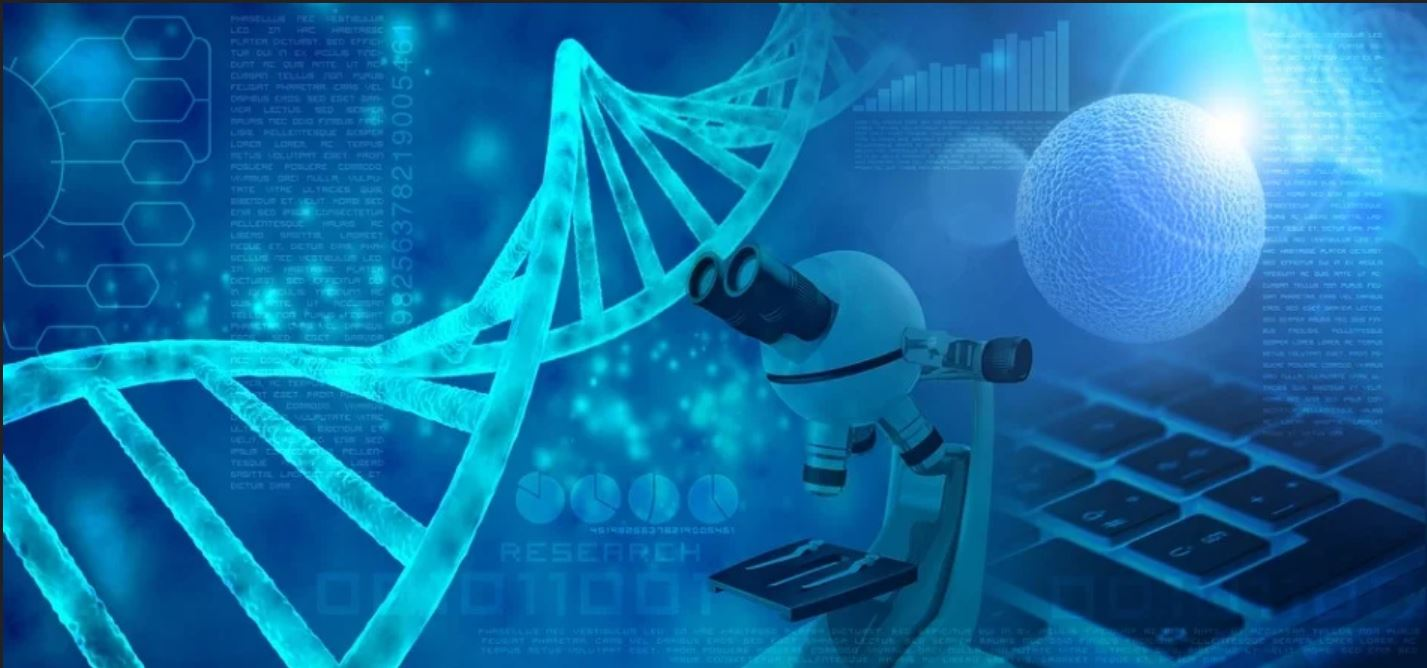

##**Drug Discovery - Análise dos dados genéticos**

## **Verificando a versão do Python**

A versão do Python utilizada neste notebook é obtida abaixo:

In [ ]:
from platform import python_version
print('Versão da Linguagem Python usada neste Notebook:', python_version())

Versão da Linguagem Python usada neste Notebook: 3.7.10


## **Obtendo os dados**

###**Importando as bibliotecas necessárias**

In [243]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
from cycler import cycler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import plotly.offline as py
import plotly.graph_objs as go
sns.set()

###**Importando os dados genéticos**
Como o arquivo que contém os dados está em formato comprimido(.zip), temos que informar o tipo de compressão para o pandas realizar a descompactação.
 

In [104]:
url_dados='https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_experimentos.zip?raw=true'
dados=pd.read_csv(url_dados, compression='zip')
dados

,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397

###**Criando as variáveis utilizadas neste notebook:**

In [168]:
mapa = {'droga': 'composto'}
dados.rename(columns=mapa, inplace=True)

cod_compostos = dados['composto'].value_counts().index[0:11]

corr = dados.loc[:,'g-0':'g-50'].corr()
corr_celular = dados.loc[:,'c-0':'c-50'].corr()

dados_resultados = pd.read_csv('https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_resultados.csv?raw=true')

contagem_moa = dados_resultados.drop('id', axis=1).sum().sort_values(ascending=False)

dados_resultados['n_moa'] = dados_resultados.drop('id', axis=1).sum(axis=1)
dados_resultados['ativo_moa'] = (dados_resultados['n_moa'] != 0)

dados_combinados = pd.merge(dados, dados_resultados[['id','n_moa', 'ativo_moa']], on='id')

dados_resultados['eh_controle'] = (dados['tratamento'] == 'com_controle')
dados_combinados1 = pd.merge(dados, dados_resultados[['id','n_moa', 'ativo_moa','eh_controle']], on='id')

enc = OneHotEncoder(sparse=False)
encodado = enc.fit_transform(np.asarray(dados['tempo']).reshape(-1,1))
dados_resultados['24'] = encodado[:,0]
dados_resultados['48'] = encodado[:,1]
dados_resultados['72'] = encodado[:,2]
dados_combinados2 = pd.merge(dados, dados_resultados[['id','n_moa', 'ativo_moa','eh_controle','24','48','72']], on='id')

O dataframe referente aos resultados do experimento será útil para análises profundas e predições mais na frente:

In [139]:
dados_resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,n_moa,ativo_moa
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,True
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,True


## **Efetuando algumas análises exploratórias**

Resumo do experimento:

In [55]:
print(f"Resumo do experimento:\n\nTotal de dados {len(dados['id'])}\n")
tipo_dados = dados['droga'].nunique()
print('Quantidade total de drogas investigadas no experimento:', tipo_dados)
print('\nDroga utilizada para grupo de controle:')
display(dados.query('tratamento == "com_controle"').value_counts('droga'))
print()
trat_dados = dados.groupby('tratamento')['droga'].nunique()
print('Quantidade total de drogas por tratamento:\n\n', trat_dados)
print('\nQuantidade de grupos por classe de tratamento:')
print ('Classes de tratamento')
dados['tratamento'].value_counts()

Resumo do experimento:

Total de dados 23814

Quantidade total de drogas investigadas no experimento: 3289

Droga utilizada para grupo de controle:


droga
cacb2b860    1866
dtype: int64


Quantidade total de drogas por tratamento:

 tratamento
com_controle       1
com_droga       3288
Name: droga, dtype: int64

Quantidade de grupos por classe de tratamento:
Classes de tratamento


com_droga       21948
com_controle     1866
Name: tratamento, dtype: int64

Verificação quando aos mecanismos de ação (MoA) ativados nos grupos de tratamento do experimento. *True* significa MoA ativado e *False* significa MoA não ativado. Observar que no grupo de controle não houve ativação, o que é um resultado esperado para este grupo:

In [138]:
moa_droga = dados_combinados.query('tratamento == "com_droga"' )['ativo_moa'].value_counts()
moa_controle = dados_combinados.query('tratamento == "com_controle"' )['ativo_moa'].value_counts()
print('Mecanismos de ação ativados no grupo experimental:')
display(moa_droga)
print('\nMecanismos de ação ativados no grupo de controle:')
display(moa_controle)

Mecanismos de ação ativados no grupo experimental:


True     14447
False     7501
Name: ativo_moa, dtype: int64


Mecanismos de ação ativados no grupo de controle:


False    1866
Name: ativo_moa, dtype: int64

Análise quantitativa em números absolutos e proporcionais das doses ministradas aos grupos de tratamento de acordo com os tempos de exposição aos compostos.

In [79]:
com_droga = dados[dados['tratamento']=='com_droga'].groupby(['dose','tempo']).count()['tratamento'] 
com_controle = dados[dados['tratamento']=='com_controle'].groupby(['dose','tempo']).count()['tratamento'] 
concatenado_num = pd.concat([com_controle,com_droga],axis=1)
concatenado_num.columns = ['com_controle','com_droga']
concatenado_perc = pd.concat([com_controle,com_droga],axis=1)
concatenado_perc.columns = ['com_controle(%)','com_droga(%)']
c1 = concatenado_num
c2 = concatenado_perc.div(concatenado_num.sum(axis=1),axis=0)
display(c1,c2*100)

com_controle  com_droga
dose tempo                         
D1   24              301       3585
     48              343       4011
     72              307       3600
D2   24              305       3581
     48              305       3591
     72              305       3580

com_controle(%)  com_droga(%)
dose tempo                               
D1   24            7.745754     92.254246
     48            7.877814     92.122186
     72            7.857691     92.142309
D2   24            7.848688     92.151312
     48            7.828542     92.171458
     72            7.850708     92.149292

Principais métricas relativas às expressões gênicas:

In [6]:
dados.loc[:,'g-0':'g-771'].describe().T

,count,mean,std,min,25%,50%,75%,max
g-0,23814.0,0.248366,1.393399,-5.513,-0.473075,-0.00885,0.525700,10.000
g-1,23814.0,-0.095684,0.812363,-5.737,-0.562200,-0.04660,0.403075,5.039
g-2,23814.0,0.152253,1.035731,-9.104,-0.437750,0.07520,0.663925,8.257
g-3,23814.0,0.081971,0.950012,-5.998,-0.429575,0.00805,0.463400,10.000
g-4,23814.0,0.057347,1.032091,-6.369,-0.470925,-0.02690,0.465375,10.000
...,...,...,...,...,...,...,...,...
g-767,23814.0,-0.076251,1.115477,-10.000,-0.506200,0.00990,0.511175,6.317
g-768,23814.0,0.134162,0.951264,-4.269,-0.353100,0.00540,0.409075,10.000
g-769,23814.0,-0.128018,1.230636,-10.000,-0.544600,0.00060,0.498500,5.911
g-770,23814.0,-0.219210,1.326193,-10.000,-0.554400,0.02870,0.496400,10.000


Principais métricas relativas à viabilidade celular:

In [7]:
dados.loc[:,'c-0':'c-99'].describe().T

,count,mean,std,min,25%,50%,75%,max
c-0,23814.0,-0.355156,1.752565,-10.0,-0.549300,-0.00900,0.448975,3.365
c-1,23814.0,-0.455359,2.004962,-10.0,-0.538425,0.00980,0.476875,3.915
c-2,23814.0,-0.480542,2.039346,-10.0,-0.550375,-0.00400,0.460575,2.970
c-3,23814.0,-0.377666,1.554583,-10.0,-0.601975,-0.03905,0.413100,2.408
c-4,23814.0,-0.493552,2.091888,-10.0,-0.559975,0.01140,0.470300,4.555
...,...,...,...,...,...,...,...,...
c-95,23814.0,-0.353726,1.629291,-10.0,-0.567975,-0.01025,0.444750,2.814
c-96,23814.0,-0.463485,2.059725,-10.0,-0.552575,-0.00125,0.465225,3.505
c-97,23814.0,-0.378241,1.703615,-10.0,-0.561000,-0.00680,0.446400,2.924
c-98,23814.0,-0.470252,1.834828,-10.0,-0.592600,0.01400,0.461275,3.111


Comparando valores de expressão gênica e viabilidade celular em relação às doses ministradas:

In [ ]:
m1 = pd.melt(dados,id_vars=['dose'],value_vars=['g-0'], var_name='exp_gen')
m2 = pd.melt(dados,id_vars=['dose'],value_vars=['c-0'], var_name='viab_cel')
display(m1, m2)

,dose,exp_gen,value
0,D1,g-0,1.0620
1,D1,g-0,0.0743
2,D1,g-0,0.6280
3,D1,g-0,-0.5138
4,D2,g-0,-0.3254
...,...,...,...
23809,D2,g-0,0.1394
23810,D2,g-0,-1.3260
23811,D2,g-0,0.3942
23812,D1,g-0,0.6660


,dose,viab_cel,value
0,D1,c-0,-0.0600
1,D1,c-0,0.0927
2,D1,c-0,-0.1312
3,D1,c-0,-0.3998
4,D2,c-0,-0.3774
...,...,...,...
23809,D2,c-0,0.4224
23810,D2,c-0,0.2144
23811,D2,c-0,1.0650
23812,D1,c-0,0.5377


Identificando os 10 principais tipos de MoA de acordo com o número de ativações proporcionadas por cada um:

In [143]:
contagem_moa = dados_resultados.drop(['id', 'n_moa', 'ativo_moa'], axis=1).sum().sort_values(ascending=False)
contagem_moa = contagem_moa.reset_index()
contagem_moa.rename(columns={'index':'MOA',0: 'Contagem'}, inplace=True)
contagem_moa['sufixo'] = contagem_moa['MOA'].apply(lambda x: x.split('_')[-1])
contagem_moa

,MOA,Contagem,sufixo
0,nfkb_inhibitor,832,inhibitor
1,proteasome_inhibitor,726,inhibitor
2,cyclooxygenase_inhibitor,435,inhibitor
3,dopamine_receptor_antagonist,424,antagonist
4,serotonin_receptor_antagonist,404,antagonist
...,...,...,...
201,protein_phosphatase_inhibitor,6,inhibitor
202,autotaxin_inhibitor,6,inhibitor
203,diuretic,6,diuretic
204,erbb2_inhibitor,1,inhibitor


##**Analisando classes de tratamento e compostos das futuras drogas**

<p align = "justify">Um experimento controlado é um teste científico feito sob condições controladas, o que significa que apenas um (ou poucos) fatores são alterados a cada vez, enquanto todos os outros são mantidos constantes. 
<br>
<p align = "justify">Num experimento controlado e comparativo, dois experimentos idênticos são conduzidos. Em um deles, com o grupo controle, o fator testado não é aplicado – recebem um tratamento padrão, um placebo ou nenhum tratamento. Em outro – o tratamento – o fator testado é aplicado. Pode haver mais de um grupo de tratamento, mais de um grupo de controle ou ambos.
<br>
<p align = "justify">Em geral, um experimento controlado deve ter sempre um grupo controle como referência para comparação. No entanto, pode haver vários grupos experimentais, cada um com um tratamento um pouco diferente aplicado à ele. No entanto, é possível usar o mesmo grupo de controle para mais de um caso, o que poderia explicar a menor quantidade no grupo de controle, em relação ao experimental.

Diferença quantitativa entre os grupos de tratamento no experimento:

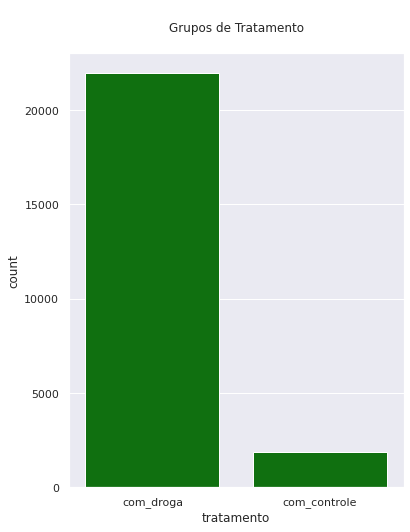

In [194]:
sns.set()
plt.figure(figsize=(6, 8))
ax = sns.countplot(x = 'tratamento', data=dados, color='green')
ax.set_title('\nGrupos de Tratamento\n')
plt.show()

Distribuição de frequência entre os grupos de tratamento no experimento:

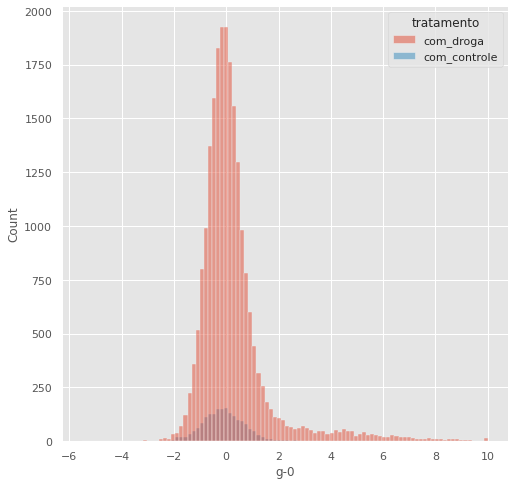

In [192]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
sns.histplot(data=dados, x='g-0', bins=100, hue='tratamento')
plt.show()

Verificando os valores apenas positivos da expressão gênica *g-0*:
<br>Faremos uma *query* para filtrar esses valores, fazendo uma alteração nos títulos das colunas do nosso dataframe para elimininar o hífen('-') que costuma gerar erros em consultas via *query*.

In [98]:
novo_nome_coluna = []
for coluna in nome_das_colunas:
  coluna = coluna.replace('-', '_')
  novo_nome_coluna.append(coluna)
dados.columns = novo_nome_coluna 
dados.head()
dados_filtrados.head(15)

,id,tratamento,tempo,dose,droga,g_0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12,g_13,g_14,g_15,g_16,g_17,g_18,g_19,g_20,g_21,g_22,g_23,g_24,g_25,g_26,g_27,g_28,g_29,g_30,g_31,g_32,g_33,g_34,...,c_60,c_61,c_62,c_63,c_64,c_65,c_66,c_67,c_68,c_69,c_70,c_71,c_72,c_73,c_74,c_75,c_76,c_77,c_78,c_79,c_80,c_81,c_82,c_83,c_84,c_85,c_86,c_87,c_88,c_89,c_90,c_91,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
6,id_001bd861f,com_droga,24,D2,746ca1f5a,2.0440,1.7000,-1.5390,5.9440,-2.1670,-4.0360,3.6950,1.4530,0.9724,-2.4380,5.1340,-4.6600,5.7960,4.9700,1.5540,2.4790,-3.8010,-1.0230,5.3110,-0.5660,-4.4450,1.2210,1.3750,0.3932,0.3392,4.3510,5.7540,-1.6590,5.3000,5.6050,5.5320,3.7860,0.9197,1.9310,2.4870,...,-0.8904,2.0590,0.5052,0.6890,0.5340,0.5135,0.6507,0.9838,0.4532,-0.3212,0.2662,0.6864,1.6300,1.3810,0.0061,0.2908,0.2598,0.1266,-0.3526,1.1750,-1.1030,1.3650,1.0610,0.4034,1.0880,-0.4230,0.4013,0.1726,0.7464,0.9418,0.1855,1.1720,0.8325,0.6486,0.8090,1.5880,2.4670,0.0357,0.1351,-0.3179
7,id_0020d0484,com_droga,48,D1,8b87a7a83,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,...,-0.2623,-0.5500,-0.0530,0.2077,-0.0825,0.2156,0.8142,1.0990,1.0860,0.4011,-0.1342,0.4653,-0.1104,0.3935,1.2370,-0.5072,0.0351,0.5084,-0.1248,0.4351,0.1389,0.6726,0.6070,0.3431,-0.4116,0.1194,0.3420,0.1331,0.8541,0.6282,0.3230,-0.4140,0.2532,0.0513,0.8600,1.4250,0.6633,0.4562,-0.9622,0.0260
12,id_0025c5949,com_droga,48,D1,eecfc72b8,0.0030,0.7189,1.8890,-0.8711,1.3130,1.1830,0.6150,0.0542,0.6055,-0.1215,0.1276,-0.5602,0.3466,1.1740,-0.1456,-1.1280,1.5940,0.9063,-0.0337,-1.1290,-0.3092,-0.5587,0.1028,0.1620,1.4900,-0.4658,0.4781,-1.1230,0.4536,-0.1112,0.7514,-0.4620,0.4518,-0.6326,0.3331,...,-0.3484,0.8300,-0.5587,0.1799,0.5830,0.0983,0.2988,0.0975,1.1280,0.7290,0.1707,0.3828,-0.3779,1.1070,1.5850,0.6812,-0.3933,0.5975,-0.4338,-0.2589,-0.2221,0.9797,0.2261,0.6232,1.2590,0.0049,0.6824,1.4920,1.5780,0.1561,1.1080,-0.3030,1.1730,0.7277,0.6671,0.7115,0.8592,0.2429,0.3453,0.3083
14,id_002d31e2c,com_droga

Quantidades de compostos para cada tempo de exposição em horas no experimento:

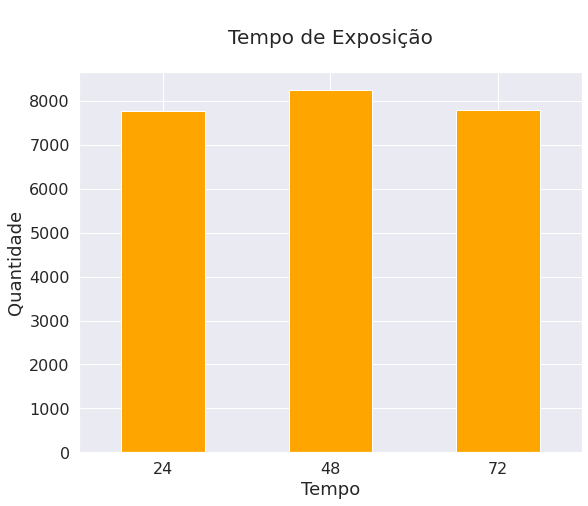

In [91]:
valore_tempo = dados['tempo'].value_counts(ascending=True)
plt.figure(figsize=(9, 7))
valore_tempo = dados['tempo'].value_counts(ascending=True)
ax = valore_tempo.sort_index().plot.bar(color=['orange'])
ax.set_title('\nTempo de Exposição\n', fontsize=20)
ax.set_xlabel('Tempo', fontsize=18)
ax.set_ylabel('Quantidade', fontsize=18)
plt.xticks(rotation = 0, fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Os compostos mais utlizados no experimento:

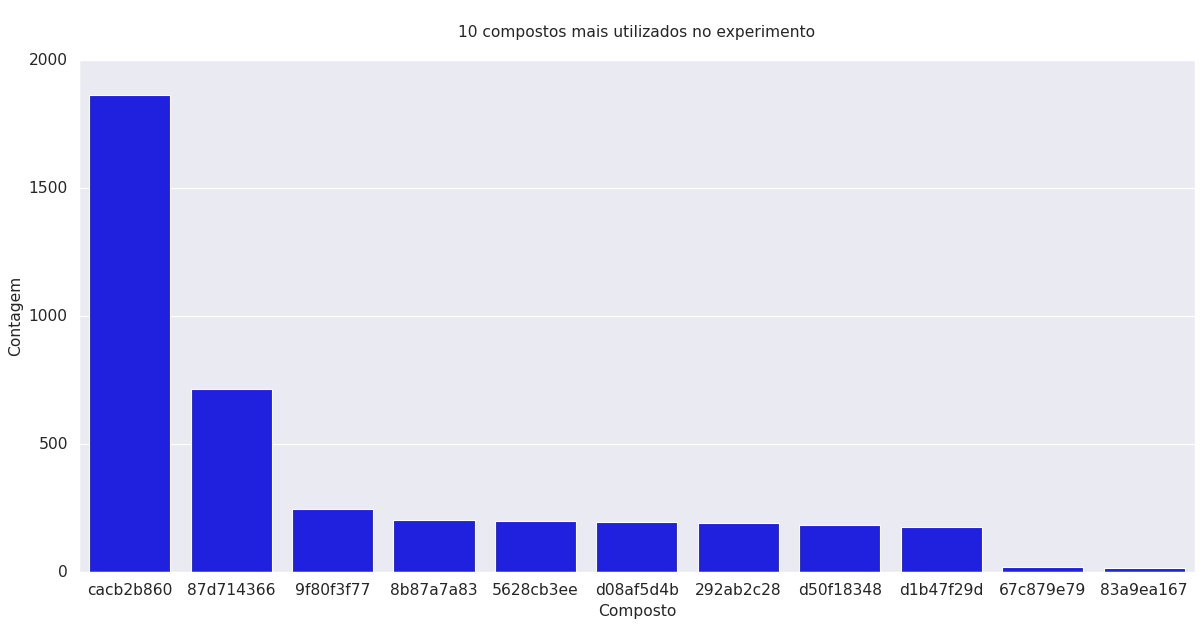

In [213]:
sns.set()      
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.figure(figsize=(18, 8))
ax = sns.countplot(x = 'composto', data=dados.query('composto in @cod_compostos'), order=cod_compostos, color='blue')
ax.set_title('\n10 compostos mais utilizados no experimento\n')
ax.set_ylabel('Contagem')
ax.set_xlabel('Composto')
plt.show()

Analisando graficamente os 10 principais tipos de MoA de acordo com o número de ativações proporcionadas por cada um:

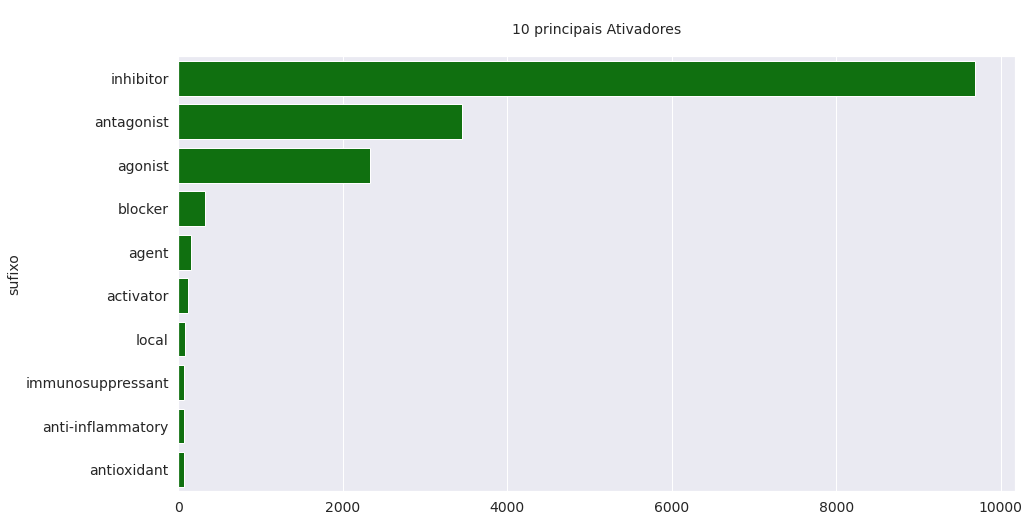

In [162]:
contagem_MOAs_ativos_por_sufixos = contagem_moa.groupby('sufixo').sum()['Contagem'].sort_values(ascending=False)
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.barplot(y=contagem_MOAs_ativos_por_sufixos.head(10).index,
            x=contagem_MOAs_ativos_por_sufixos.head(10).values, ax=ax, orient='h', color='green')
ax.set_title("\n10 principais Ativadores\n")

plt.show()

Através do gráfico interativo abaixo, é possível analisar a correlação entre dois pares de expressões gênicas(*g-0* e *g-8*) nas suas primeiras 500 linhas do dataframe. Pode-se realizar zoom e recortes no gráfico para ampliar detalhes dos dados plotados: 

In [284]:
trace = go.Scatter(x = dados['g-0'].head(500),
                   y = dados['g-8'].head(500),
                   mode = 'markers',
                   marker = {  'color' : '#e74c3c', 'line' : {'width': 1, 'color': '#c0392b'}},
                   opacity=.8)
data = [trace]
py.iplot(data)

In [286]:
trace = go.Scatter(x = dados['g-10'].head(500),
                   y = dados['c-8'].head(500),
                   mode = 'markers',
                   marker = {  'color' : '#e74c3c', 'line' : {'width': 1, 'color': 'green'}},
                   opacity=.8)
data = [trace]
py.iplot(data)

Verificando a frequência das expressões gênicas e viabilidades celulares. Utilizamos a biblioteca Seaborn em combinação com matplotlib/pyplot:

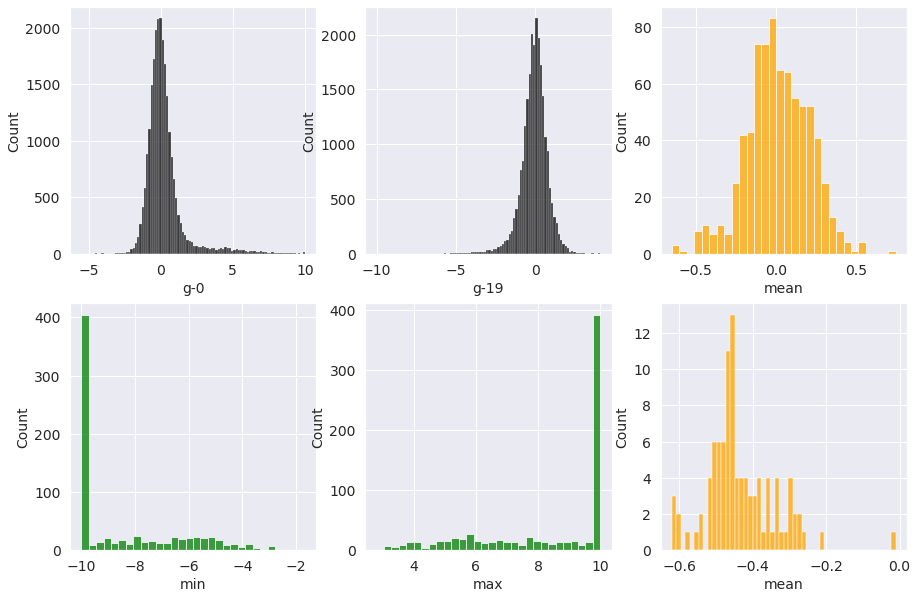

In [159]:
plt.figure(figsize=(15, 10))
ax1=plt.subplot(2,3,1)
sns.histplot(data=dados['g-0'],bins=100, color='black')
ax2=plt.subplot(2,3,2)
sns.histplot(data=dados['g-19'],bins=100, color='black')
ax3=plt.subplot(2,3,3)
sns.histplot(data=dados.loc[:,'g-0':'g-771'].describe().T['mean'],bins=30, color='orange')
ax4=plt.subplot(2,3,4)
sns.histplot(data=dados.loc[:,'g-0':'g-771'].describe().T['min'],bins=30, color='green')
ax5=plt.subplot(2,3,5)
sns.histplot(data=dados.loc[:,'g-0':'g-771'].describe().T['max'],bins=30, color='green')
ax6=plt.subplot(2,3,6)
sns.histplot(data=dados.loc[:,'c-0':'c-99'].describe().T['mean'],bins=50, color='orange')
axes=[ax1,ax2,ax3,ax4,ax5,ax6]

Verificando a tendência central de valores das expressões gênicas e viabilidades celulares:

O primeiro boxplot abaixo permite interação:

In [279]:
trace1 = go.Box(y=dados['g-0'], x=dados['dose'] , 
                name = 'g-0 vs. dose',
                marker = {'color': '#f39c12'})

trace2 = go.Box(y=dados['c-0'], x=dados['dose'] ,
                name = 'c-0 vs. dose',
                marker = {'color': '#d35400'})

trace3 = go.Box(y=dados['c-15'], x=dados['tempo'] , 
                name = 'c-s5 vs. tempo',
                marker = {'color': '#e74c3c'})

data = [trace1, trace2, trace3]
layout = go.Layout(title = 'Tendência central de expressões gênicas e viabilidade celular',
                   titlefont = {'family': 'Arial',
                                'size': 22,
                                'color': '#7f7f7f'},
                   xaxis = {'title': 'Dose e Tempo'},
                   yaxis = {'title': 'Exp. genica e viab. celular'},
                   paper_bgcolor = 'rgb(243, 243, 243)',
                   plot_bgcolor = 'rgb(243, 243, 243)')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

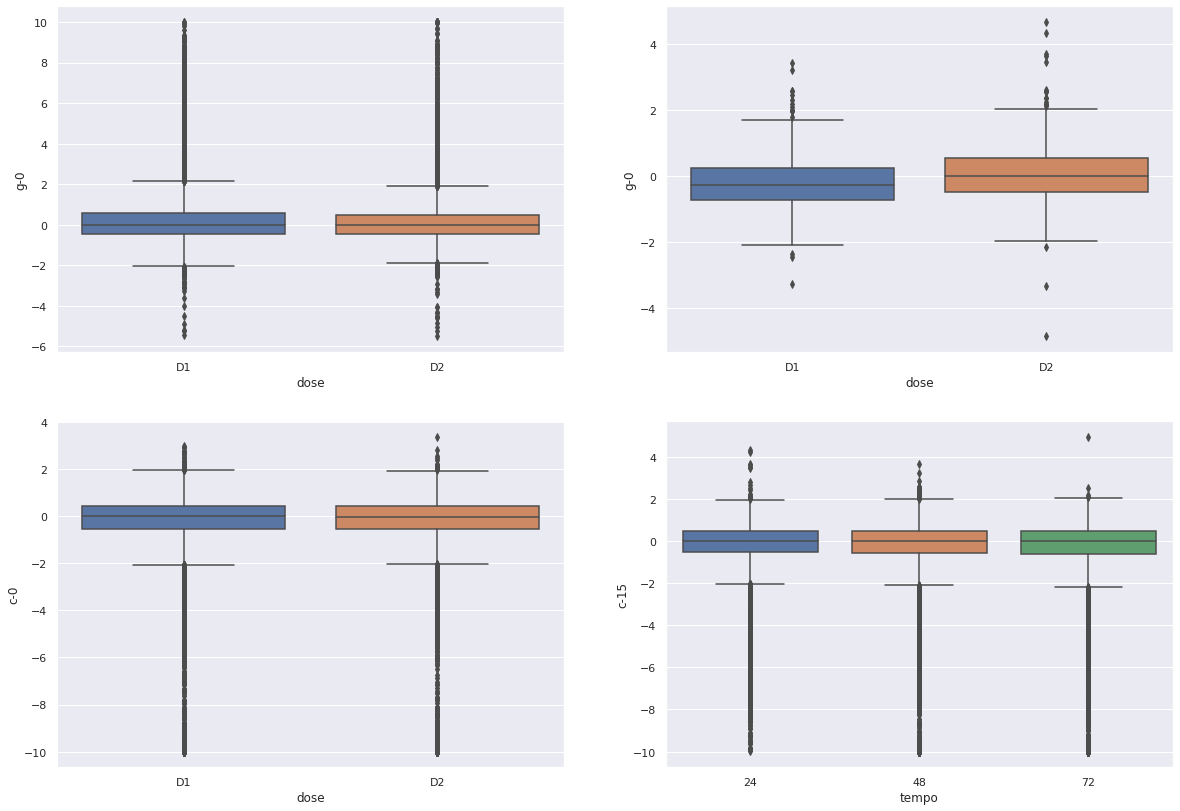

In [78]:
plt.figure(figsize=(20,14))
ay1=plt.subplot(2,2,1)
sns.boxplot(y='g-0', x='dose' , data=dados)
ay2=plt.subplot(2,2,2)
sns.boxplot(y='g-0', x='dose' , data=dados.query('composto == "cacb2b860"'))
ay3=plt.subplot(2,2,3)
sns.boxplot(y='c-0', x='dose' , data=dados)
ay4=plt.subplot(2,2,4)
sns.boxplot(y='c-15', x='tempo' , data=dados)
plt.show()
yaxes=[ay1,ay2,ay3,ay4]

<p align = "justify">Quanto maior o valor das colunas de *g-0* a *g-771*, maior será a expressão de determinado gene ao composto que está sendo submetido. Além disso, quanto maior o valor das colunas de *c-0* a *c-99*, maior a sobrevivência de determinada célula ao composto que está sendo submetida. Então, pode-se concluir que, havendo correlação entre *g* e *c*, maior ou menor chance determinada célula tem de sobreviver perante uma determinada expressão gênica. Os gráficos seguintes podem ajudar a visualizar melhor este cenário.

<p align = "justify">O mapa de calor abaixo mostra as correlações existentes entre as primeiras 20 expressões gênicas e as primeiras 20 viabilidades celulares, onde a cor mais *quente* indica uma correlação positiva (se *g* sobe, *c* também sobe) e vice-versa. Deve-se atentar, porém, que correlação nem sempre implica em causalidade.

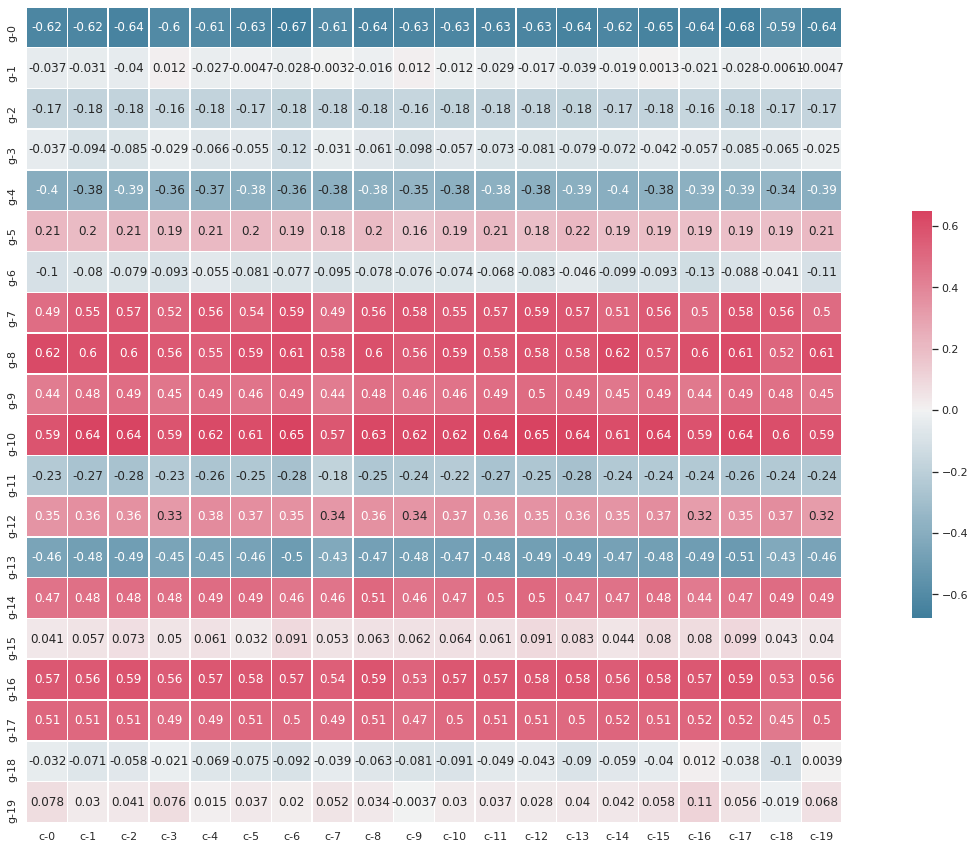

In [95]:
corr = dados.loc[:,'g-0':'c-99'].corr()
corr_celular_genes = corr.loc['g-0':'g-19','c-0':'c-19']
f, ax = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(230, 5, as_cmap=True)
sns.heatmap(corr_celular_genes, cmap=cmap, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True)

Selecionando um par de correlações do mapa de calor, por exemplo, entre *g-10* e *c-8*, pode-se verificar que, à medida que a expressão gênica aumenta, mais viável a sobrevivência daquela célula:

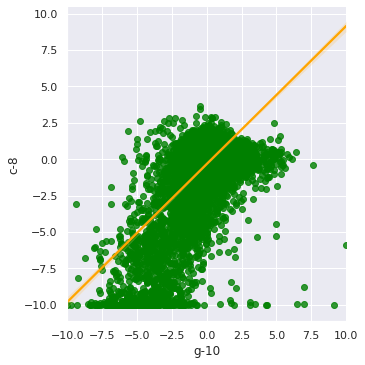

In [ ]:
sns.lmplot(data=dados, x='g-10', y='c-8', line_kws={'color': 'orange'}, scatter_kws={'color': 'green'})

Por outro lado, ao analisarmos o par formado entre *g-0* e *c-20* verificamos o oposto, ou seja, a maior expressão gênica tende a reduzir a viabilidade de sobrevivência da célula:

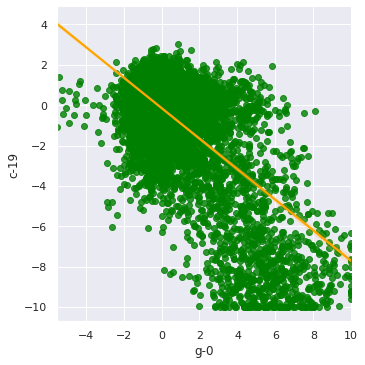

In [94]:
sns.lmplot(data=dados, x='g-0', y='c-19', line_kws={'color': 'orange'}, scatter_kws={'color': 'green'})

Também existem casos em que praticamente não existe correlação entre pares, como, por exemplo, entre *g-1* e *c-14*:

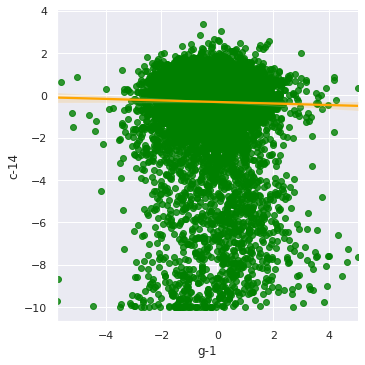

In [ ]:
sns.lmplot(data=dados, x='g-1', y='c-14', line_kws={'color': 'orange'}, scatter_kws={'color': 'green'})

Podemos criar também um mapa de calor em formato triangular, analisando apenas as correlações entre as diferentes expressões gênicas.

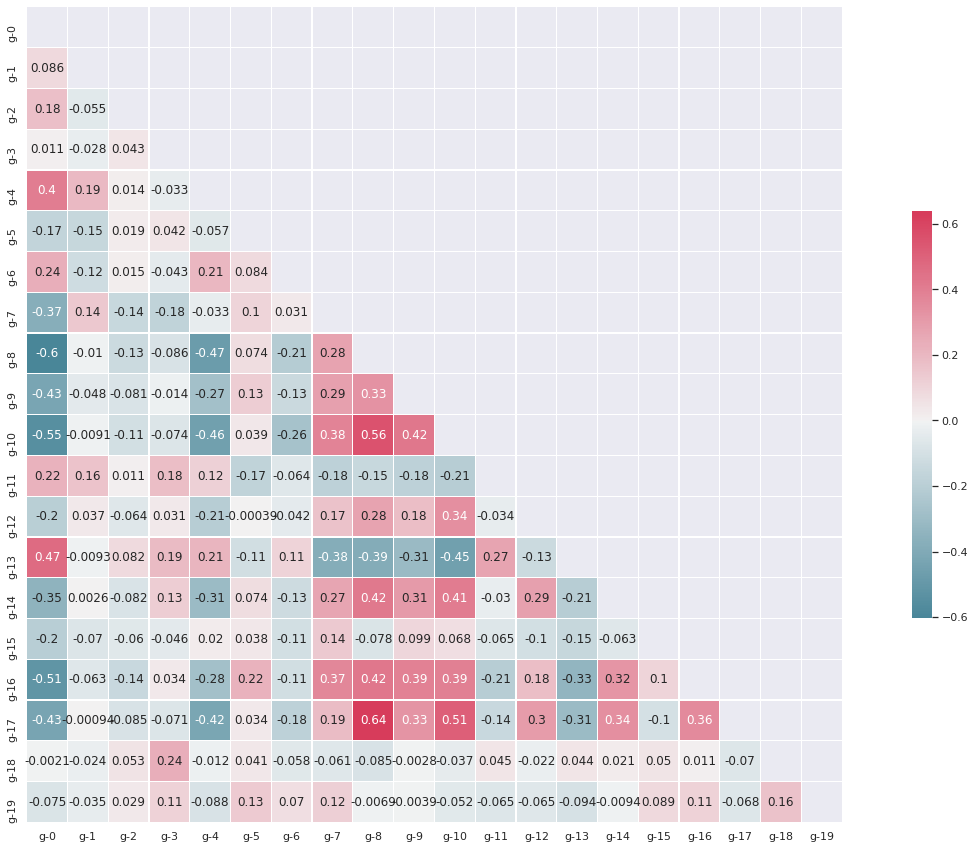

In [106]:
corr_genes = dados.loc[:,'g-0':'g-19'].corr()
mask = np.triu(np.ones_like(corr_genes, dtype=bool))
cmap = sns.diverging_palette(h_neg=220, h_pos=5, as_cmap=True)
plt.figure(figsize=(25, 15))

sns.heatmap(corr_genes, mask=mask, cmap=cmap, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .5}, annot=True)

Analogamente, podemos criar um mapa de calor em formato triangular, analisando apenas as correlações entre as diferentes viablidades celulares. Há indício de forte correlação positiva entre as viabilidades, significando que a tendência de crescimento nos valores correspondentes a uma célula, afeta iguamente a outra, e vice-versa.

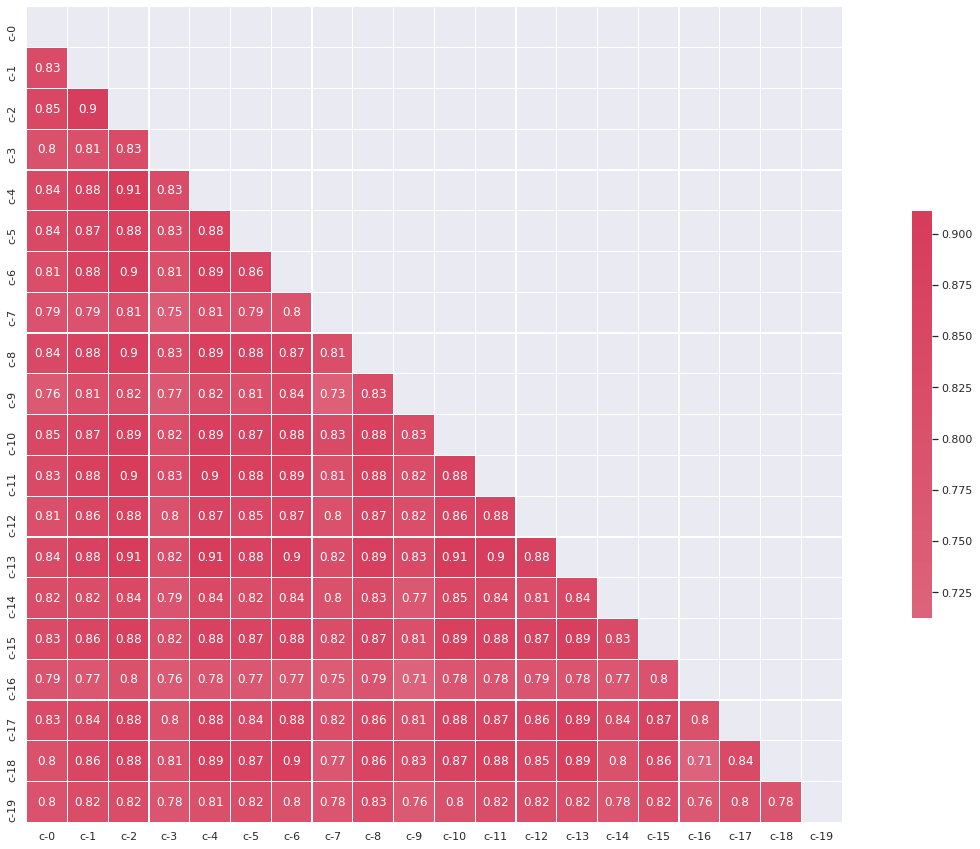

In [110]:
corr_genes = dados.loc[:,'c-0':'c-19'].corr()
mask = np.triu(np.ones_like(corr_genes, dtype=bool))
cmap = sns.diverging_palette(h_neg=220, h_pos=5, as_cmap=True)
plt.figure(figsize=(25, 15))

sns.heatmap(corr_genes, mask=mask, cmap=cmap, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .5}, annot=True)

A partir dos dataframes `dados` e `dados_combinados`, podemos treinar um modelo de ML para predizer a quantidade de MoA ativados a partir de determinado composto e respectiva assinatura celular. Primeiramente tentaremos através de regressão logística:

In [216]:
x = dados_combinados.select_dtypes('float64')
y = dados_combinados['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_rlogistica = LogisticRegression(max_iter=1000)
modelo_rlogistica.fit(x_treino, y_treino)
modelo_rlogistica.score(x_teste, y_teste)

0.6267058576527399

O resultado acima indica que o modelo obtido teve uma acurácia de aproximadamente 63%, ou seja, de cada 100 experimentos analisados ele acertaria 63 resultados. Podemos tentar outras técnicas para verificar se obteremos uma acurácia mais elevada:

In [218]:
x = dados_combinados.select_dtypes('float64')
y = dados_combinados['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

modelo_arvore = DecisionTreeClassifier(max_depth = 3)
modelo_arvore.fit(x_treino, y_treino)
modelo_arvore.score(x_teste, y_teste)

0.6105395758975436

Utilizando a técnica de árvore de decisão, obtivemos uma acurácia um pouco menor do que através da regressão logística, o que não significa que a técnica em si não retorne resultados melhores, pois há vários fatores envolvidos no resultado que o modelo retorna, inclusive relativo aos dados de treino utilizados. 
<br>
Na árvore de decisão utilizamos um `max_depth = 3`, que significa o número de níveis de decisão utilizanos. Abaixo é exibido graficamente esta situação:

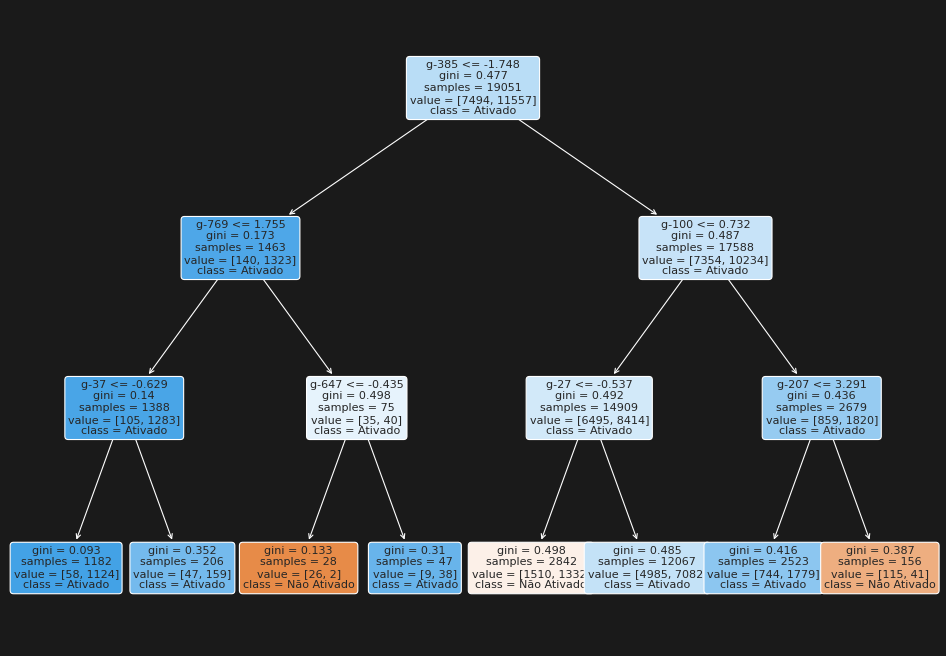

In [220]:
fig, ax = plt.subplots(figsize=(15, 10), facecolor='k')
tree.plot_tree(modelo_arvore,
               ax=ax,
               fontsize=10,
               rounded=True,
               filled=True,
               feature_names=x_treino.columns,
               class_names=['Não Ativado', 'Ativado'])

plt.show()

Tentaremos abaixo utilizar um número maior de níveis de decisão e analisar as saídas tanto para `treino` quanto para `teste`:

In [241]:
x = dados_combinados.select_dtypes('float64')
y = dados_combinados['ativo_moa'] 
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = 0.2, stratify=y, random_state=376)

teste=[]
treino=[]
for i in range(1,15):
    modelo_arvore = DecisionTreeClassifier(max_depth = i)
    modelo_arvore.fit(x_treino, y_treino)
    teste.append(modelo_arvore.score(x_teste, y_teste))
    treino.append(modelo_arvore.score(x_treino, y_treino))

As saídas são plotadas no gráfico abaixo:

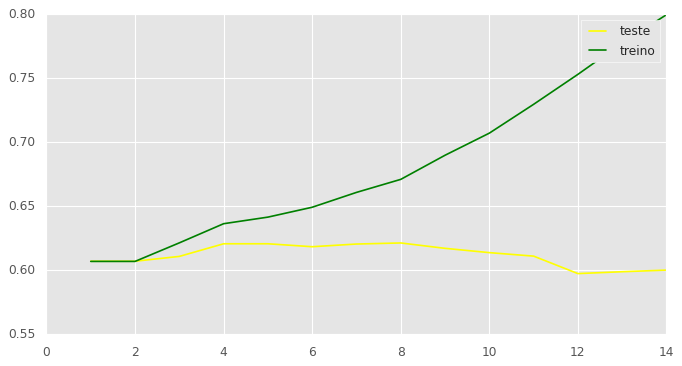

In [242]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1,15), y = teste, label='teste', color='yellow')
sns.lineplot(x=range(1,15), y = treino, label='treino', color='green')

Como vemos no gráfico acima, os resultados de acurácia para `treino` foram muito maiores do que para a variável `teste`, o que indica que, quanto mais níveis de decisão forem adicionados no processo, menor será a acurácia final do modelo, pois o mesmo se ajustará tanto sobre os dados de treino que, quando receber dados diferentes, não terá a mesma adaptação. Neste caso, dizemos que houve um *overfitting*!

## **Conclusões**

<p align = "justify">Neste projeto coletamos dados genéticos relativos a um experimento com objetivo de descobrir novos medicamentos para o tratamento de tumores malignos, haja vista a quantidade de agentes inibidores e bloqueadores celulares nos compostos. Exploramos os dados, realizamos análises, tentamos prever resultados futuros a partir dos dados históricos...tudo isso auxiliado por poderosas ferramentas de Data Science, em conjunto com Cloud Computing. 
<br>

<p align = "justify">Pudemos verificar na prática como este processo exige grande esforço de coleta, limpeza, transformação e tratamento dos dados originais, para que possam ser utilizados para as futuras análises. Muitos insights foram obtidos com este trabalho, reforçando o momento atual em que estamos em relação ao volume de dados gerados continuamente e a necessidade de aproveitá-los da melhor forma possível. 
<br>

<p align = "justify">Descobrimos também a necessidade de unir conhecimentos técnicos (hard skills) com o conhecimento do ambiente de negócios (no caso, biogenética e farmacêutica) e habilidades de comunicação dos resultados (soft skills), pois as partes interessadas em obter respostas que orientarão a tomada de decisões importantes do negócio precisam entender claramente e as conclusões apresentadas, bem como as respostas que não foram respondidas, suscitando novas abordagens em relação aos dados.
<br>

Esta imersão promovida pela Alura foi fundamental para meu processo de transição de carreira, este é apenas o primeiro passo, há muito o que ser aprendido ao longo caminho e novas oportunidades de aprendizado continuarão surgindo todos os dias. 

## **Bibliografia**
<br>

[Drug Discovery](https://en.wikipedia.org/wiki/Drug_discovery)
<br><br>

[How to use machine learning for drug discovery](https://towardsdatascience.com/how-to-use-machine-learning-for-drug-discovery-1ccb5fdf81ad)
<br><br>
[Python for drug discovery](https://www.python.org/success-stories/python-for-collaborative-drug-discovery/)
<br><br>
[Nature - Drug Discovery Last News](https://www.nature.com/subjects/drug-discovery)
<br><br>
[Gráficos interativos utilizando Plotly e Python](https://paulovasconcellos.com.br/como-criar-gr%C3%A1ficos-interativos-utilizando-plotly-e-python-3eb6eda57a2b)
<br><br>
[Nanotechnology in Life Sciences](https://www.azonano.com/article.aspx?ArticleID=4659)
<br><br>
[Visualizando informações com gráfico](https://www.alura.com.br/artigos/visualizando-informacoes-com-um-grafico)
<br><br>
[Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/?v=20210503203718)
<br><br>
[Usando query - Pandas](https:https://medium.com/horadecodar/como-usar-o-query-do-pandas-fdf4a00727dc//)
<br><br>
[Pyplot - Matplotlib Documentation](https://matplotlib.org/2.0.2/api/pyplot_api.html)
<br><br>
[Seaborn Facegrid Documentation](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html)
<br><br>
[Criando anotações com Markdown](https://www.alura.com.br/artigos/criando-anotacoes-com-markdown)
<br><br>
[Outputs alternatives in Python](https://stackoverflow.com/questions/2570269/output-alternatives-in-python)

